# Estudio de la distribución de amplitudes

El experimento que hemos realizado es de conteo, es por ello que los detectores nos dan información de cuántas partículas incidentes hay pero no de sus energías.

Una forma de estudiar la energía depositada por las partículas incidentes, en este caso los $\mu$, es mediante las amplitudes de la señal que se ha medido en cada detección. Con esto y la fórmula de Bethe, la cual describe la energía depositada por partículas cargadas en movimiento en un medio, podremos correlacionar las amplitudes y las energías perdidas en un detector o en varios.

In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy.optimize as so
import scipy.special as se #para el factorial
import pandas as pd
from decimal import * #para las cifras significativas
import timeit
import seaborn as sns #para el mapa de calor

Leemos los datos desde el archivo .txt

In [2]:
def leerArchivo(archivo):
    completo = open(archivo, 'r')
    tiempos = []
    datos = []
    contador = 0
    for linea in completo: #recorremos cada línea del archivo
        if len(linea) == 1: #len cuenta los bytes de cada linea: si tiene 1 byte es porque cuenta el salto de linea como \n
            continue
        else: #en otro caso, será algún dato de interés
            numero_elementos = linea.split() #guardamos los elementos de la línea
            if len(numero_elementos) == 1: #si hay un solo elemento, será el tiempo unix
                tiempos.append(numero_elementos)
                contador += 1
            else: #en otro caso, será alguno de los otros datos
                datos.append(numero_elementos)
                contador += 1
    
    #el resultado de este bucle es una lista de listas, lo cual no nos interesa porque queremos trabajar con elementos que sean números
    tamaño = len(tiempos)
    tiempos_unix = [] #almacenamos aquí el tiempo unix
    for i in range(tamaño):
        tiempos_unix.append(int(tiempos[i][0]))
    
    #leemos también los datos de los tiempos en ns y las amplitudes de la señal
    tiempos_volt = [] #tiempos de registro de amplitudes de señal (cada 4 ns)
    numero_iteraciones = len(datos)
    for j in range(numero_iteraciones):
        tiempos_volt.append(int(datos[j][0]))
    medidasA = [] #amplitudes detector A
    for k in range(numero_iteraciones):
        medidasA.append(int(datos[k][1]))
    medidasB = [] #amplitudes detector B
    for l in range(numero_iteraciones):
        medidasB.append(int(datos[l][2]))
    medidasC = [] #amplitudes detector C
    for m in range(numero_iteraciones):
        medidasC.append(int(datos[m][3]))
    medidasD = [] #amplitudes detector D
    for n in range(numero_iteraciones):
        medidasD.append(int(datos[n][4]))
    
    return tiempos_unix, tiempos_volt, medidasA, medidasB, medidasC, medidasD, datos

Primero usaremos los datos recogidos por nosotros. Después usaremos los proporcionados por el profesor para distintos umbrales, donde podremos realizar un estudio dependiendo de esta última variable.

In [38]:
medidas_mu = leerArchivo('coincidenciasAB.txt')[6]
unix = leerArchivo('coincidenciasAB.txt')[0]

#la función nos devuelve listas con strings, así que pasamos los elementos a float
for i in range(len(medidas_mu)):
    for j in range(len(medidas_mu[i])):
        if type(medidas_mu[i][j]) == str:
            medidas_mu[i][j] = float(medidas_mu[i][j])

#número de triggers = número de tiempos unix
n_sep = len(unix)
#creamos una lista de n_sep listas vacías donde almacenaremos los datos de cada medida
datos = [[] for k in range(n_sep)]

i = 1
for j in range(len(datos)):
    while medidas_mu[i-1][0] < medidas_mu[i][0] and i < (len(medidas_mu)-1):
        datos[j].append(medidas_mu[i-1])
        i += 1
    else:
        i += 1
#quitamos las listas vacías
for k in datos:
    if len(k) == 0:
        datos.remove(k)

In [39]:
t_min_A = []
t_min_B = []
t_min_C = []
t_min_D = []

V_min_A = []
V_min_B = []
V_min_C = []
V_min_D = []

def parabola(x, a, b, c):
    return a*x**2 + b*x + c

for i in range(len(datos)):
    
    t = []
    
    detA = []
    detB = []
    detC = []
    detD = []
    
    for j in range(len(datos[i])):
        t.append(datos[i][j][0])
        detA.append(datos[i][j][1])
        detB.append(datos[i][j][2])
        detC.append(datos[i][j][3])
        detD.append(datos[i][j][4])
    
    indice_min_A = detA.index(min(detA))
    indice_min_B = detB.index(min(detB))
    indice_min_C = detC.index(min(detC))
    indice_min_D = detD.index(min(detD))
    
    if indice_min_A == (len(detA)-1):
        detA.append(detA[indice_min_A-1])
        t.append(t[indice_min_A] + t[indice_min_A] - t[indice_min_A-1])
    if indice_min_B == (len(detB)-1):
        detB.append(detD[indice_min_B-1])
        t.append(t[indice_min_B] + t[indice_min_B] - t[indice_min_B-1])
    if indice_min_C == (len(detC)-1):
        detC.append(detC[indice_min_C-1])
        t.append(t[indice_min_C] + t[indice_min_C] - t[indice_min_C-1])
    if indice_min_D == (len(detD)-1):
        detD.append(detD[indice_min_D-1])
        t.append(t[indice_min_D] + t[indice_min_D] - t[indice_min_D-1])

    lA = indice_min_A
    tA = [t[lA-1], t[lA], t[lA+1]]
    lB = indice_min_B
    tB = [t[lB-1], t[lB], t[lB+1]]
    lC = indice_min_C
    tC = [t[lC-1], t[lC], t[lC+1]]
    lD = indice_min_D
    tD = [t[lD-1], t[lD], t[lD+1]]

    ajusteA = [detA[lA-1], detA[lA], detA[lA+1]]
    ajusteB = [detB[lB-1], detB[lB], detB[lB+1]]
    ajusteC = [detC[lC-1], detC[lC], detC[lC+1]]
    ajusteD = [detD[lD-1], detD[lD], detD[lD+1]]

    if min(ajusteA) != 0:
        solA, covA = so.curve_fit(parabola, tA, ajusteA)
        aA = solA[0] ; bA = solA[1] ; cA = solA[2]
    else:
        aA = 0 ; bA = 0 ; cA = 0
    ##############################################
    if min(ajusteB) != 0:
        solB, covB = so.curve_fit(parabola, tB, ajusteB)
        aB = solB[0] ; bB = solB[1] ; cB = solB[2]
    else:
        aB = 0 ; bB = 0 ; cB = 0
    ##############################################
    if min(ajusteC) != 0:
        solC, covC = so.curve_fit(parabola, tC, ajusteC)
        aC = solC[0] ; bC = solC[1] ; cC = solC[2]
    else:
        aC = 0 ; bC = 0 ; cC = 0
    ##############################################
    if min(ajusteD) != 0:
        solD, covD = so.curve_fit(parabola, tD, ajusteD)
        aD = solD[0] ; bD = solD[1] ; cD = solD[2]
    else:
        aD = 0 ; bD = 0 ; cD = 0
    ##############################################
        
    t_aux = np.linspace(30,100,1000)

    VA = aA*t_aux**2 + bA*t_aux + cA
    VB = aB*t_aux**2 + bB*t_aux + cB
    VC = aC*t_aux**2 + bC*t_aux + cC
    VD = aD*t_aux**2 + bD*t_aux + cD

    V_min_A.append(min(VA))
    V_min_B.append(min(VB))
    V_min_C.append(min(VC))
    V_min_D.append(min(VD))

    t_min_A.append(t_aux[list(VA).index(min(VA))])
    t_min_B.append(t_aux[list(VB).index(min(VB))])
    t_min_C.append(t_aux[list(VC).index(min(VC))])
    t_min_D.append(t_aux[list(VD).index(min(VD))])          

Limpiamos los datos obtenidos, ya que a veces se obtienen voltajes positivos (lo que nos dará resultados sin sentido)

In [316]:
contador = 0
for i in V_min_A:
    if i > 1 or i < 3000:
        V_min_A.remove(i)
        V_min_B.remove(V_min_B[contador])
        V_min_C.remove(V_min_C[contador])
        V_min_D.remove(V_min_D[contador])
        contador += 1
    else:
        contador += 1
contador = 0
for i in V_min_B:
    if i > 1 or i < 3000:
        V_min_B.remove(i)
        V_min_A.remove(V_min_A[contador])
        V_min_C.remove(V_min_C[contador])
        V_min_D.remove(V_min_D[contador])
        contador += 1
    else:
        contador += 1
contador = 0
for i in V_min_C:
    if i > 1 or i < 3000:
        V_min_C.remove(i)
        V_min_A.remove(V_min_A[contador])
        V_min_B.remove(V_min_B[contador])
        V_min_D.remove(V_min_D[contador])
        contador += 1
    else:
        contador += 1
contador = 0
for i in V_min_D:
    if i > 1 or i < 3000:
        V_min_D.remove(i)
        V_min_A.remove(V_min_A[contador])
        V_min_B.remove(V_min_B[contador])
        V_min_C.remove(V_min_C[contador])
        contador += 1
    else:
        contador += 1

### Caracterización de un pulso

In [228]:
datos[1][1]

[44.0, -684.0, -428.0, -931.0, -805.0]

In [229]:
tiempo_ns = []
A = []
B = []
C = []
D = []
for i in range(len(datos[1])):
    tiempo_ns.append(datos[1][i][0])
    A.append(datos[1][i][1])
    B.append(datos[1][i][2])
    C.append(datos[1][i][3])
    D.append(datos[1][i][4])

[40.0, 44.0, 48.0, 52.0, 56.0, 60.0, 64.0, 68.0, 72.0, 76.0, 80.0, 84.0, 88.0]


In [244]:
t_min_A_aux = []
t_min_B_aux = []
t_min_C_aux = []
t_min_D_aux = []

V_min_A_aux = []
V_min_B_aux = []
V_min_C_aux = []
V_min_D_aux = []

def parabola(x, a, b, c):
    return a*x**2 + b*x + c

taux = []
    
detA_aux = []
detB_aux = []
detC_aux = []
detD_aux = []
    
for j in range(len(datos[1])):
    taux.append(datos[1][j][0])
    detA_aux.append(datos[1][j][1])
    detB_aux.append(datos[1][j][2])
    detC_aux.append(datos[1][j][3])
    detD_aux.append(datos[1][j][4])
    
indice_min_A_aux = detA_aux.index(min(detA_aux))
indice_min_B_aux = detB_aux.index(min(detB_aux))
indice_min_C_aux = detC_aux.index(min(detC_aux))
indice_min_D_aux = detD_aux.index(min(detD_aux))


lA_aux = indice_min_A_aux
tA_aux = [taux[lA-1], taux[lA], taux[lA+1]]
lB_aux = indice_min_B_aux
tB_aux = [taux[lB-1], taux[lB], taux[lB+1]]
lC_aux = indice_min_C_aux
tC_aux = [taux[lC-1], taux[lC], taux[lC+1]]
lD_aux = indice_min_D_aux
tD_aux = [taux[lD-1], taux[lD], taux[lD+1]]

ajusteA_aux = [detA_aux[lA_aux-1], detA_aux[lA_aux], detA_aux[lA_aux+1]]
ajusteB_aux = [detB_aux[lB_aux-1], detB_aux[lB_aux], detB_aux[lB_aux+1]]
ajusteC_aux = [detC_aux[lC_aux-1], detC_aux[lC_aux], detC_aux[lC_aux+1]]
ajusteD_aux = [detD_aux[lD_aux-1], detD_aux[lD_aux], detD_aux[lD_aux+1]]

solA_aux, covA_aux = so.curve_fit(parabola, tA_aux, ajusteA_aux)
aA_aux = solA_aux[0] ; bA_aux = solA_aux[1] ; cA_aux = solA_aux[2]
##############################################
solB_aux, covB_aux = so.curve_fit(parabola, tB_aux, ajusteB_aux)
aB_aux = solB_aux[0] ; bB_aux = solB_aux[1] ; cB_aux = solB_aux[2]
##############################################
solC_aux, covC_aux = so.curve_fit(parabola, tC_aux, ajusteC_aux)
aC_aux = solC_aux[0] ; bC_aux = solC_aux[1] ; cC_aux = solC_aux[2]
##############################################
solD_aux, covD_aux = so.curve_fit(parabola, tD_aux, ajusteD_aux)
aD_aux = solD_aux[0] ; bD_aux = solD_aux[1] ; cD_aux = solD_aux[2]
##############################################
        
taux_aux = np.linspace(30,100,1000)

VA_aux = aA_aux*taux_aux**2 + bA_aux*taux_aux + cA_aux
VB_aux = aB_aux*taux_aux**2 + bB_aux*taux_aux + cB_aux
VC_aux = aC_aux*taux_aux**2 + bC_aux*taux_aux + cC_aux
VD_aux = aD_aux*taux_aux**2 + bD_aux*taux_aux + cD_aux

V_min_A_aux.append(min(VA_aux))
V_min_B_aux.append(min(VB_aux))
V_min_C_aux.append(min(VC_aux))
V_min_D_aux.append(min(VD_aux))

t_min_A_aux.append(taux_aux[list(VA_aux).index(min(VA_aux))])
t_min_B_aux.append(taux_aux[list(VB_aux).index(min(VB_aux))])
t_min_C_aux.append(taux_aux[list(VC_aux).index(min(VC_aux))])
t_min_D_aux.append(taux_aux[list(VD_aux).index(min(VD_aux))])

C:\Users\sergi\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


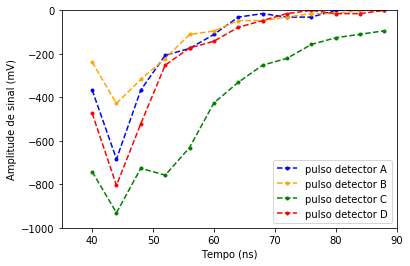

In [284]:
#puntos experimentales
plt.plot(tiempo_ns, A, '.--', color='blue', label='pulso detector A')
plt.plot(tiempo_ns, B, '.--', color='orange', label='pulso detector B')
plt.plot(tiempo_ns, C, '.--', color='green', label='pulso detector C')
plt.plot(tiempo_ns, D, '.--', color='red', label='pulso detector D')
#ajustes
"""plt.plot(taux_aux, VA_aux, linestyle=':', color='darkblue')
plt.plot(taux_aux, VB_aux, linestyle=':', color='darkorange')
plt.plot(taux_aux, VC_aux, linestyle=':', color='darkgreen')
plt.plot(taux_aux, VD_aux, linestyle=':', color='darkred')
#mínimos
plt.plot(t_min_A_aux, V_min_A_aux, 'o', color='darkblue', label='$V_{min} A$')
plt.plot(t_min_B_aux, V_min_B_aux, 'o', color='darkorange', label='$V_{min} B$')
plt.plot(t_min_C_aux, V_min_C_aux, 'o', color='darkgreen', label='$V_{min} C$')
plt.plot(t_min_D_aux, V_min_D_aux, 'o', color='darkred', label='$V_{min} D$')"""
plt.xlabel('Tempo (ns)')
plt.ylabel('Amplitude de sinal (mV)')
plt.xlim(35, 90)
plt.ylim(-1000, 0)
plt.legend(loc='best', ncol=1)
#plt.savefig('pulso_sin_ajuste.pdf')

### Estudio de correlaciones:

Definimos la correlación entre pares de detectores, co la amplitud de A en el eje X para todos los casos.

Coeficiente de correlación entre amplitudes en A y B:  0.6402


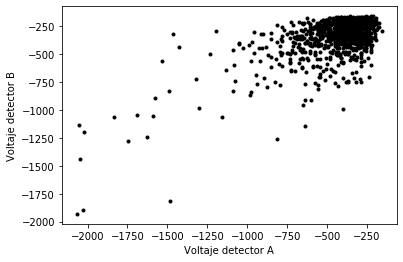

In [294]:
correlacion_AB = np.corrcoef(V_min_A, V_min_B)
print('Coeficiente de correlación entre amplitudes en A y B: ', round(correlacion_AB[0][1], 4))

plt.plot(V_min_A, V_min_B, 'k.')
plt.xlabel('Voltaje detector A')
plt.ylabel('Voltaje detector B')
plt.show()

Coeficiente de correlación entre amplitudes en A y C:  0.6334


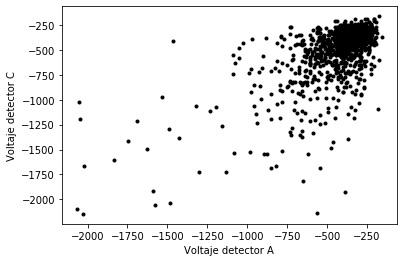

In [295]:
correlacion_AC = np.corrcoef(V_min_A, V_min_C)
print('Coeficiente de correlación entre amplitudes en A y C: ', round(correlacion_AC[0][1], 4))

plt.plot(V_min_A, V_min_C, 'k.')
plt.xlabel('Voltaje detector A')
plt.ylabel('Voltaje detector C')
plt.show()

Coeficiente de correlación entre amplitudes en A y D:  0.4865


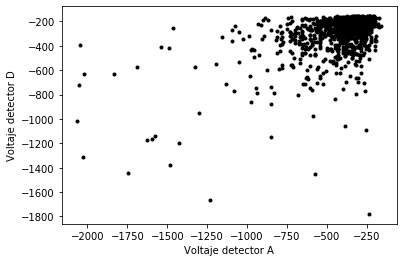

In [296]:
correlacion_AD = np.corrcoef(V_min_A, V_min_D)
print('Coeficiente de correlación entre amplitudes en A y D: ', round(correlacion_AD[0][1], 4))

plt.plot(V_min_A, V_min_D, 'k.')
plt.xlabel('Voltaje detector A')
plt.ylabel('Voltaje detector D')
plt.show()

In [40]:
contador = 0
for i in V_min_C:
    if i > 1:
        V_min_C.remove(i)
        V_min_A.remove(V_min_A[contador])
        V_min_B.remove(V_min_B[contador])
        V_min_D.remove(V_min_D[contador])
        contador += 1
    else:
        contador += 1
contador = 0
for i in V_min_D:
    if i > 1:
        V_min_D.remove(i)
        V_min_A.remove(V_min_A[contador])
        V_min_B.remove(V_min_B[contador])
        V_min_C.remove(V_min_C[contador])
        contador += 1
    else:
        contador += 1

Coeficiente de correlación entre amplitudes en A e B:  0.6385
Coeficiente de correlación entre amplitudes en A e C:  0.4185
Coeficiente de correlación entre amplitudes en A e D:  0.0278


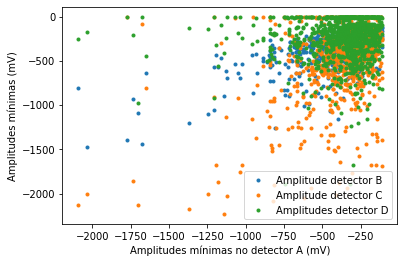

In [41]:
correlacion_AB = np.corrcoef(V_min_A, V_min_B)
print('Coeficiente de correlación entre amplitudes en A e B: ', round(correlacion_AB[0][1], 4))

plt.plot(V_min_A, V_min_B, '.', label='Amplitude detector B')
#plt.xlabel('Amplitude detector A')
#plt.ylabel('Voltaje detector B')

correlacion_AC = np.corrcoef(V_min_A, V_min_C)
print('Coeficiente de correlación entre amplitudes en A e C: ', round(correlacion_AC[0][1], 4))

plt.plot(V_min_A, V_min_C, '.', label='Amplitude detector C')
#plt.xlabel('Amplitude detector A')
#plt.ylabel('Voltaje detector C')

correlacion_AD = np.corrcoef(V_min_A, V_min_D)
print('Coeficiente de correlación entre amplitudes en A e D: ', round(correlacion_AD[0][1], 4))

plt.plot(V_min_A, V_min_D, '.', label='Amplitudes detector D')
plt.xlabel('Amplitudes mínimas no detector A (mV)')
plt.ylabel('Amplitudes mínimas (mV)')

plt.legend(loc='lower right')
plt.savefig('corrAB_aux.png')
plt.show()


In [136]:
#####################################################

Coeficiente de correlación entre amplitudes en B y C:  0.2915


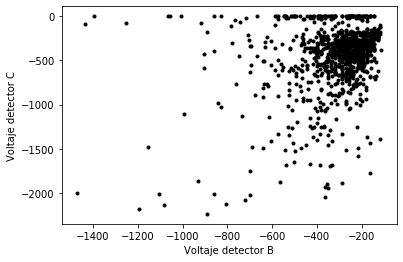

In [137]:
correlacion_BC = np.corrcoef(V_min_B, V_min_C)
print('Coeficiente de correlación entre amplitudes en B y C: ', round(correlacion_BC[0][1], 4))

plt.plot(V_min_B, V_min_C, 'k.')
plt.xlabel('Voltaje detector B')
plt.ylabel('Voltaje detector C')
plt.show()

Coeficiente de correlación entre amplitudes en B y D:  -0.0084


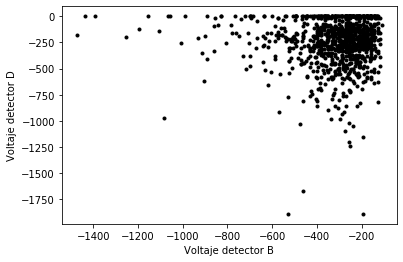

In [138]:
correlacion_BD = np.corrcoef(V_min_B, V_min_D)
print('Coeficiente de correlación entre amplitudes en B y D: ', round(correlacion_BD[0][1], 4))

plt.plot(V_min_B, V_min_D, 'k.')
plt.xlabel('Voltaje detector B')
plt.ylabel('Voltaje detector D')
plt.show()

Coeficiente de correlación entre amplitudes en B y C:  0.2915
Coeficiente de correlación entre amplitudes en B y D:  -0.0084


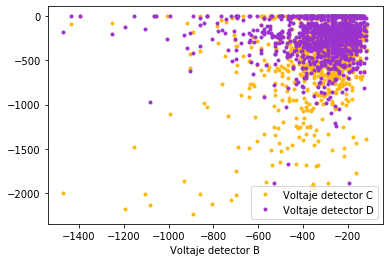

In [139]:
correlacion_BC = np.corrcoef(V_min_B, V_min_C)
print('Coeficiente de correlación entre amplitudes en B y C: ', round(correlacion_BC[0][1], 4))

plt.plot(V_min_B, V_min_C, '.', color='#FFB90F', label='Voltaje detector C')
plt.xlabel('Voltaje detector B')

correlacion_BD = np.corrcoef(V_min_B, V_min_D)
print('Coeficiente de correlación entre amplitudes en B y D: ', round(correlacion_BD[0][1], 4))

plt.plot(V_min_B, V_min_D, '.', color='#9A32CD', label='Voltaje detector D')

plt.legend()
plt.show()

In [140]:
#######################################################

Coeficiente de correlación entre amplitudes en C y D:  0.0839


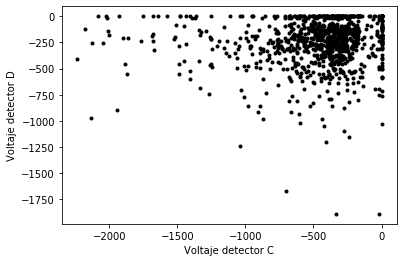

In [141]:
correlacion_CD = np.corrcoef(V_min_C, V_min_D)
print('Coeficiente de correlación entre amplitudes en C y D: ', round(correlacion_CD[0][1], 4))

plt.plot(V_min_C, V_min_D, 'k.')
plt.xlabel('Voltaje detector C')
plt.ylabel('Voltaje detector D')
plt.show()

In [19]:
indices = np.linspace(1,1000,1000)

ex = pd.DataFrame(data = ([0, 0, 0, 0]))
ex2 = pd.DataFrame(data = ([0, 0, 0, 0]))
VA = pd.DataFrame(data = V_min_A, index = indices)
VB = pd.DataFrame(data = V_min_B, index = indices)
VC = pd.DataFrame(data = V_min_C, index = indices)
VD = pd.DataFrame(data = V_min_D, index = indices)

df = pd.concat([ex,VA,VB,VC,VD,ex2], axis=1)
df.columns = ['','$V_{min}$ A', '$V_{min}$ B', '$V_{min}$ C', '$V_{min}$ D', '']

In [20]:
df.corr()

,,$V_{min}$ A,$V_{min}$ B,$V_{min}$ C,$V_{min}$ D,
,NaN,NaN,NaN,NaN,NaN,NaN
$V_{min}$ A,NaN,1.000000,0.646875,-0.069772,-0.154816,NaN
$V_{min}$ B,NaN,0.646875,1.000000,-0.039405,-0.154377,NaN
$V_{min}$ C,NaN,-0.069772,-0.039405,1.000000,-0.001086,NaN
$V_{min}$ D,NaN,-0.154816,-0.154377,-0.001086,1.000000,NaN
,NaN,NaN,NaN,NaN,NaN,NaN


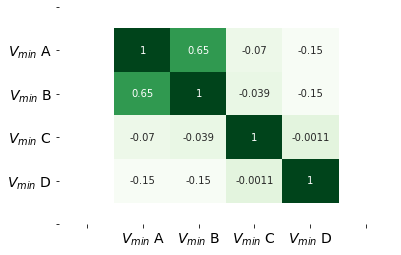

In [21]:
sns.heatmap(df.corr(), annot=True, cmap='Greens', cbar=False)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=14)
plt.yticks(rotation = 0)
plt.savefig('mapacalorAB.pdf', dpi=300, bbox_inches='tight', linewidths=1.5)